# Evaluating bias of ML against CERRA data for Precipitation

Training Period: 1985 to 2015
Prediction period: 2016 to 2020

In [1]:
PREDICTAND = 'pr'

## Imports

In [2]:
# builtins
import datetime
import warnings
import calendar

# externals
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score

In [3]:
# mapping from predictands to variable names
NAMES = {'pr': 'precipitation'}

# dataset names mapping
PRED = 'BilinearInterP'
TRUE = 'CERRA'

In [4]:
y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/larger_alps/ml_Predictions/pr/RandomForestRegressor_pr_ztuvq_500_850_mslppr_1mm_dem_sa_doy.nc")
y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/larger_alps/CERRA/pr/CERRA_total_precipitation_1985_2020.nc")

In [5]:
# subset to time period covered by predictions
y_true = y_true.sel(time=y_pred.time)

def get_time_range(dataset):
    time_coord = dataset.time

    # Get the starting and ending years
    start_year = time_coord.min().dt.year.item()
    end_year = time_coord.max().dt.year.item()

    return str(start_year), str(end_year)

start_year, end_year = get_time_range(y_pred)
print("Starting year:", start_year)
print("Ending year:", end_year)


Starting year: 2016
Ending year: 2020


In [6]:
y_pred = y_pred.rename({'pr': 'precipitation'})
y_pred

<xarray.Dataset>
Dimensions:        (time: 1826, y: 103, x: 125)
Coordinates:
  * time           (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * y              (y) float64 50.52 50.45 50.37 50.3 ... 43.27 43.2 43.13 43.05
  * x              (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
Data variables:
    precipitation  (time, y, x) float64 ...

In [7]:
Y_interp = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/larger_alps/REANALYSIS/ERA5/total_precipitation/ERA5_total_precipitation_1981_2020.nc")
Y_interp = Y_interp.sel(time=y_pred.time)
y_pred = Y_interp

y_pred = y_pred.rename({'tp': 'precipitation'})
y_pred = y_pred.rename({'longitude': 'x','latitude': 'y'})

In [8]:
# Minor changes to be made to dataset to align and making it compliant
# y_true = y_true.drop_vars("spatial_ref")
y_true = y_true.rename({'tp': 'precipitation'})
#y_pred = y_pred.rename({'pr': 'precipitation'})
y_true = y_true.rename({'longitude': 'x','latitude': 'y'})
y_true


<xarray.Dataset>
Dimensions:        (x: 125, y: 103, time: 1826)
Coordinates:
  * x              (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y              (y) float64 50.52 50.45 50.37 50.3 ... 43.27 43.2 43.13 43.05
  * time           (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
Data variables:
    precipitation  (time, y, x) float32 ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             French Weather Service - Toulouse
    GRIB_centre:             lfpw
    GRIB_centreDescription:  French Weather Service - Toulouse
    history:                 Sun Jul 09 11:36:34 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [9]:
y_true

<xarray.Dataset>
Dimensions:        (x: 125, y: 103, time: 1826)
Coordinates:
  * x              (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y              (y) float64 50.52 50.45 50.37 50.3 ... 43.27 43.2 43.13 43.05
  * time           (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
Data variables:
    precipitation  (time, y, x) float32 ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             French Weather Service - Toulouse
    GRIB_centre:             lfpw
    GRIB_centreDescription:  French Weather Service - Toulouse
    history:                 Sun Jul 09 11:36:34 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [10]:
y_pred

<xarray.Dataset>
Dimensions:        (time: 1826, x: 125, y: 103)
Coordinates:
  * time           (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * x              (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y              (y) float64 50.52 50.45 50.37 50.3 ... 43.27 43.2 43.13 43.05
Data variables:
    precipitation  (time, y, x) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Jul 03 11:21:32 2023: cdo -O -s -remapbil,/mnt/CEPH_PRO...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [11]:
y_pred

<xarray.Dataset>
Dimensions:        (time: 1826, x: 125, y: 103)
Coordinates:
  * time           (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * x              (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y              (y) float64 50.52 50.45 50.37 50.3 ... 43.27 43.2 43.13 43.05
Data variables:
    precipitation  (time, y, x) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Jul 03 11:21:32 2023: cdo -O -s -remapbil,/mnt/CEPH_PRO...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [12]:
y_true

<xarray.Dataset>
Dimensions:        (x: 125, y: 103, time: 1826)
Coordinates:
  * x              (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y              (y) float64 50.52 50.45 50.37 50.3 ... 43.27 43.2 43.13 43.05
  * time           (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
Data variables:
    precipitation  (time, y, x) float32 ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             French Weather Service - Toulouse
    GRIB_centre:             lfpw
    GRIB_centreDescription:  French Weather Service - Toulouse
    history:                 Sun Jul 09 11:36:34 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [13]:
# aligndata_varsasets
if len(y_pred.data_vars) > 1:
    y_true, y_pred_pr = xr.align(y_true.precipitation, y_pred.precipitation, join='override')
else:
    y_true, y_pred_pr = xr.align(y_true.precipitation, y_pred.precipitation, join='override')

In [14]:
# mask missing values
mask = ~np.isnan(y_true)
y_pred_pr = y_pred_pr.where(mask, other=np.nan)    
if len(y_pred.data_vars) > 1:
    y_pred_prob = y_pred_prob.where(mask, other=np.nan)

In [15]:
# calculate monthly precipitation (mm / month)
y_pred_m = y_pred_pr.resample(time='1M').sum(skipna=False)
y_true_m = y_true.resample(time='1M').sum(skipna=False)

In [16]:
# calculate mean annual cycle
y_pred_ac = y_pred_m.groupby('time.month').mean(dim=('y', 'x', 'time'), skipna=True).values.squeeze()
y_true_ac = y_true_m.groupby('time.month').mean(dim=('y', 'x', 'time'), skipna=True).values.squeeze()

In [17]:
def anomalies(ds, timescale='time.dayofyear', standard=False):
        # group dataset by time scale
        groups = ds.groupby(timescale).groups

        # compute anomalies over time
        anomalies = {}
        for time, time_scale in groups.items():
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=RuntimeWarning)
                # anomaly = (x(t) - mean(x, t))
                anomalies[time] = (ds.isel(time=time_scale) -
                                   ds.isel(time=time_scale).mean(dim='time'))

                # standardized anomaly = (x(t) - mean(x, t)) / std(x, t)
                if standard:
                    anomalies[time] /= ds.isel(time=time_scale).std(dim='time')

        # concatenate anomalies and sort chronologically
        anomalies = xr.concat(anomalies.values(), dim='time')
        anomalies = anomalies.sortby(anomalies.time)

        return anomalies

# compute daily anomalies
y_pred_anom = anomalies(y_pred_pr, timescale='time.month')
y_true_anom = anomalies(y_true, timescale='time.month')

### Coefficient of determination

In [18]:
# get predicted and observed daily anomalies
y_pred_av = y_pred_anom.values.flatten()
y_true_av = y_true_anom.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_av) & ~np.isnan(y_true_av))
y_pred_av = y_pred_av[mask]
y_true_av = y_true_av[mask]

# get predicted and observed monthly means
y_pred_mv = y_pred_m.values.flatten()
y_true_mv = y_true_m.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_mv) & ~np.isnan(y_true_mv))
y_pred_mv = y_pred_mv[mask]
y_true_mv = y_true_mv[mask]

# calculate coefficient of determination on monthly means
r2_mm = r2_score(y_true_mv, y_pred_mv)
print('R2 on monthly means: {:.2f}'.format(r2_mm))

# calculate coefficient of determination on daily anomalies
r2_anom = r2_score(y_true_av, y_pred_av)
print('R2 on daily anomalies: {:.2f}'.format(r2_anom))

R2 on monthly means: 0.69
R2 on daily anomalies: 0.44


### Coefficient of determination: Spatially

In [19]:
# iterate over the grid points
r2 = np.ones((2, len(y_pred_m.x), len(y_pred_m.y)), dtype=np.float32) * np.nan
for i, _ in enumerate(y_pred_m.x):
    for j, _ in enumerate(y_pred_m.y):
        # get observed and predicted monthly precipitation for current grid point
        point_true = y_true_m.isel(x=i, y=j)
        point_pred = y_pred_m.isel(x=i, y=j)
        
        # remove missing values
        mask = ((~np.isnan(point_true)) & (~np.isnan(point_pred)))
        point_true = point_true[mask].values
        point_pred = point_pred[mask].values
        if point_true.size < 1:
            continue
        
        # get anomalies for current grid point
        point_anom_true = y_true_anom.isel(x=i, y=j)
        point_anom_pred = y_pred_anom.isel(x=i, y=j)
        
        # remove missing values
        mask_anom = ((~np.isnan(point_anom_true)) & (~np.isnan(point_anom_pred)))
        point_anom_true = point_anom_true[mask_anom].values
        point_anom_pred = point_anom_pred[mask_anom].values

        # compute coefficient of determination
        r2[0, i, j] = r2_score(point_true, point_pred)
        r2[1, i, j] = r2_score(point_anom_true, point_anom_pred)

/tmp/ipykernel_62231/2394193649.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  grn = cm.get_cmap('Greens', 128)
/tmp/ipykernel_62231/2394193649.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  red = cm.get_cmap('Reds_r', 128)


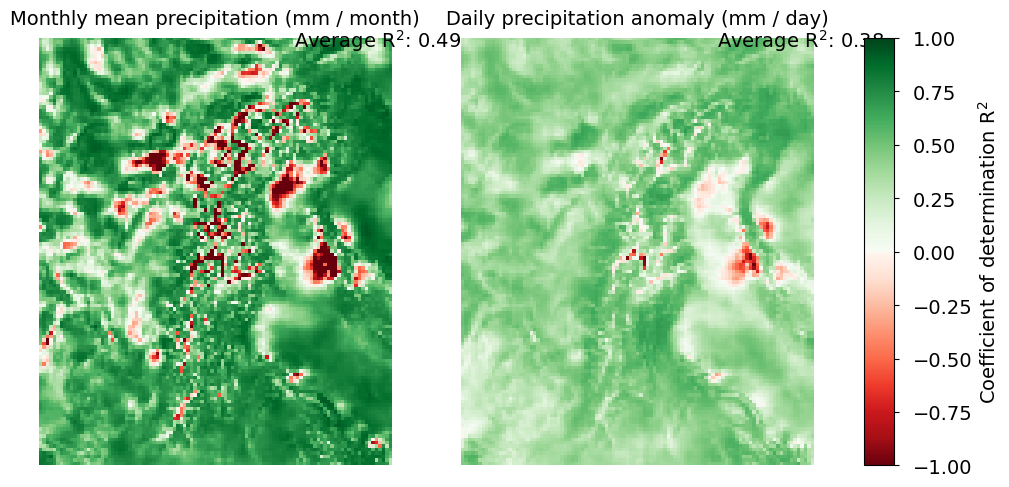

In [20]:
# define color map: red to green
grn = cm.get_cmap('Greens', 128)
red = cm.get_cmap('Reds_r', 128)
red2green = ListedColormap(np.vstack((red(np.linspace(0, 1, 128)),
                                      grn(np.linspace(0, 1, 128)))))

# plot coefficients of determination
vmin, vmax = -1, 1
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# monthly means
im0 = ax[0].imshow(r2[0, :], origin='upper', cmap=red2green, vmin=vmin, vmax=vmax)
ax[0].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[0, :])), fontsize=14, ha='right');
ax[0].set_axis_off()
ax[0].set_title('Monthly mean {} (mm / month)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# daily anomalies
im1 = ax[1].imshow(r2[1, :], origin='upper', cmap=red2green, vmin=vmin, vmax=vmax)
ax[1].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[1, :])), fontsize=14, ha='right');
ax[1].set_axis_off()
ax[1].set_title('Daily {} anomaly (mm / day)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# add colorbar 
cbar_ax_bias = fig.add_axes([ax[1].get_position().x1 + 0.05, ax[1].get_position().y0,
                             0.03, ax[1].get_position().y1 - ax[1].get_position().y0])
cbar_bias = fig.colorbar(im0, cax=cbar_ax_bias)
cbar_bias.set_label(label='Coefficient of determination R$^2$', fontsize=14)
cbar_bias.ax.tick_params(labelsize=14, pad=10)

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Figures/{}_r2_spatial.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias

Calculate yearly average bias over entire reference period:

In [21]:
# average bias of daily precipitation over reference period
y_pred_yearly_avg = y_pred_pr.groupby('time.year').mean(dim='time')
#y_refe_yearly_avg = y_refe.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')
bias_yearly_avg = ((y_pred_yearly_avg - y_true_yearly_avg) / y_true_yearly_avg) * 100
print('({}:{}) Yearly average relative bias: {:.2f}%'.format(TRUE, PRED, bias_yearly_avg.mean().item()))

(CERRA:BilinearInterP) Yearly average relative bias: 18.22%


In [22]:
# mean absolute error over reference period
mae_avg = np.abs(y_pred_yearly_avg - y_true_yearly_avg)
print('({}:{}) Yearly average MAE: {:.2f} mm'.format(TRUE, PRED, mae_avg.mean().item()))

(CERRA:BilinearInterP) Yearly average MAE: 0.56 mm


In [23]:
# root mean squared error over reference period
rmse_avg = np.sqrt(((y_pred_yearly_avg - y_true_yearly_avg) ** 2).mean())
print('({}:{}) Yearly average RMSE: {:.2f} mm / day'.format(TRUE, PRED, rmse_avg.item()))

(CERRA:BilinearInterP) Yearly average RMSE: 0.73 mm / day


In [24]:
# Pearson's correlation coefficient over reference period
for year in y_pred_yearly_avg.year:
    y_p = y_pred_yearly_avg.sel(year=year).values        
    y_t = y_true_yearly_avg.sel(year=year).values
    r, _ = stats.pearsonr(y_p[~np.isnan(y_p)], y_t[~np.isnan(y_t)])
    print('({:0d}) Pearson correlation: {:.2f}'.format(year.item(), np.asarray(r).mean()))
r, _ = stats.pearsonr(y_pred_yearly_avg.values[~np.isnan(y_pred_yearly_avg.values)],
                      y_true_yearly_avg.values[~np.isnan(y_true_yearly_avg.values)])
print('Total: {:.2f}'.format(r))

(2016) Pearson correlation: 0.81
(2017) Pearson correlation: 0.84
(2018) Pearson correlation: 0.83
(2019) Pearson correlation: 0.85
(2020) Pearson correlation: 0.83
Total: 0.83


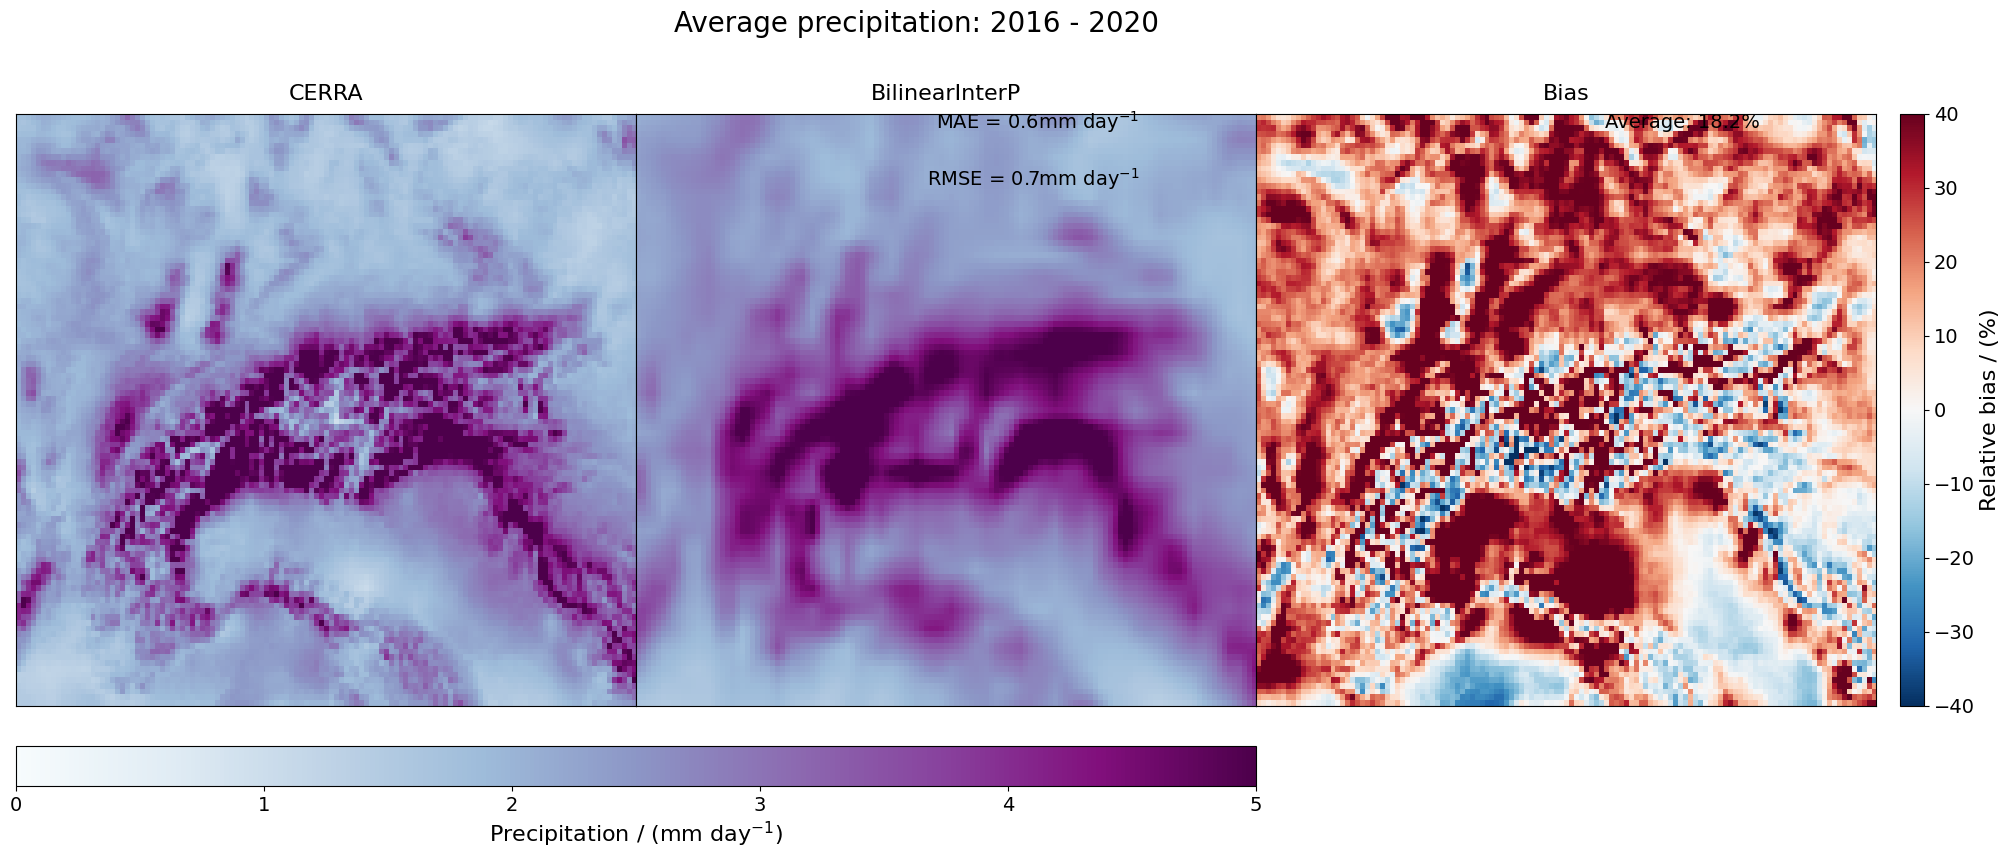

In [25]:
# plot average of observation, prediction, and bias
vmin, vmax = 0, 5
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_yearly_avg, y_pred_yearly_avg, bias_yearly_avg], axes):
    if ds is bias_yearly_avg:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-40, vmax=40)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='lower', cmap='BuPu', vmin=vmin, vmax=vmax)

# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average {}: {} - {}'.format(NAMES[PREDICTAND],start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                             0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar_bias = fig.colorbar(im2, cax=cbar_ax_bias)
cbar_bias.set_label(label='Relative bias / (%)', fontsize=16)
cbar_bias.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / '.format(NAMES[PREDICTAND].capitalize()) + '(mm day$^{-1}$)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.1f}'.format(mae_avg.mean().item()) + 'mm day$^{-1}$', fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.1f}'.format(rmse_avg.mean().item()) + 'mm day$^{-1}$', fontsize=14, ha='right')

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Figures/{}_bias.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Seasonal bias

Calculate seasonal bias:

In [26]:
# group data by season: (DJF, MAM, JJA, SON)
y_true_snl = y_true.groupby('time.season').mean(dim='time')
y_pred_snl = y_pred_pr.groupby('time.season').mean(dim='time')
bias_snl = ((y_pred_snl - y_true_snl) / y_true_snl) * 100

In [27]:
# print average bias per season: Insitu:CERRA
for season in bias_snl.season:
    print('({}:{}) Average bias for season {}: {:.1f}%'.format(TRUE, PRED, season.values.item(), bias_snl.sel(season=season).mean().item()))

(CERRA:BilinearInterP) Average bias for season DJF: 27.0%
(CERRA:BilinearInterP) Average bias for season JJA: 9.7%
(CERRA:BilinearInterP) Average bias for season MAM: 22.3%
(CERRA:BilinearInterP) Average bias for season SON: 16.2%


Plot seasonal differences, taken from the [xarray documentation](xarray.pydata.org/en/stable/examples/monthly-means.html).

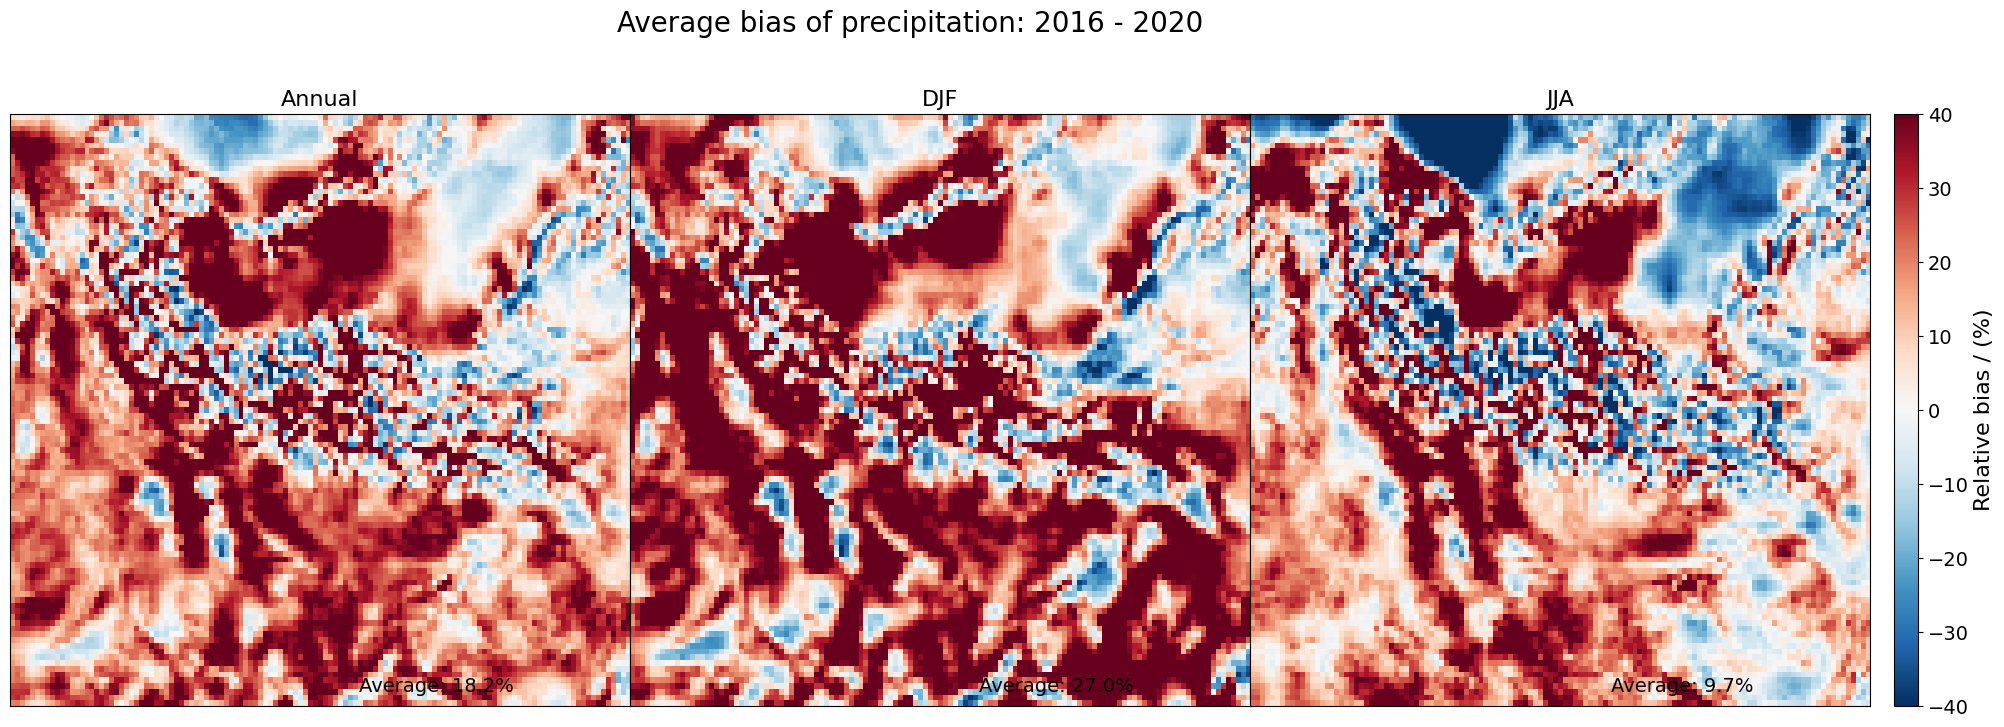

In [28]:
# plot seasonal differences
seasons = ('DJF', 'JJA')
fig, axes = plt.subplots(nrows=1, ncols=len(seasons) + 1, figsize=(24,8), sharex=True, sharey=True)
axes = axes.flatten()

# plot annual average bias
ds = bias_yearly_avg.mean(dim='year')
axes[0].imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-40, vmax=40)
axes[0].set_title('Annual', fontsize=16);
axes[0].text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')

# plot seasonal average bias
for ax, season in zip(axes[1:], seasons):
    ds = bias_snl.sel(season=season)
    ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-40, vmax=40)
    ax.set_title(season, fontsize=16);
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average bias of {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                        0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(label='Relative bias / (%)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Figures/{}_bias_seasonal.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias of extreme values

In [29]:
# extreme quantile of interest
quantile = 0.98

In [30]:
# calculate extreme quantile for each year
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    y_pred_ex = y_pred_pr.groupby('time.year').quantile(quantile, dim='time')
    y_true_ex = y_true.groupby('time.year').quantile(quantile, dim='time')

In [31]:
# calculate bias in extreme quantile for each year
bias_ex = ((y_pred_ex - y_true_ex) / y_true_ex) * 100

In [32]:
# bias of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average bias for P{:.0f}: {:.1f}%'.format(TRUE, PRED, quantile * 100, bias_ex.mean().item()))

(CERRA:BilinearInterP) Yearly average bias for P98: -0.1%


In [33]:
# mean absolute error in extreme quantile
mae_ex = np.abs(y_pred_ex - y_true_ex).mean()

In [34]:
# mae of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average MAE for P{:.0f}: {:.1f} mm / day'.format(TRUE, PRED, quantile * 100, mae_ex.item()))

(CERRA:BilinearInterP) Yearly average MAE for P98: 3.7 mm / day


In [35]:
# root mean squared error in extreme quantile
rmse_ex = np.sqrt(((y_pred_ex - y_true_ex) ** 2).mean())

In [36]:
# rmse of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average RMSE for P{:.0f}: {:.1f} mm / day'.format(TRUE, PRED, quantile * 100, rmse_ex.item()))

(CERRA:BilinearInterP) Yearly average RMSE for P98: 5.4 mm / day


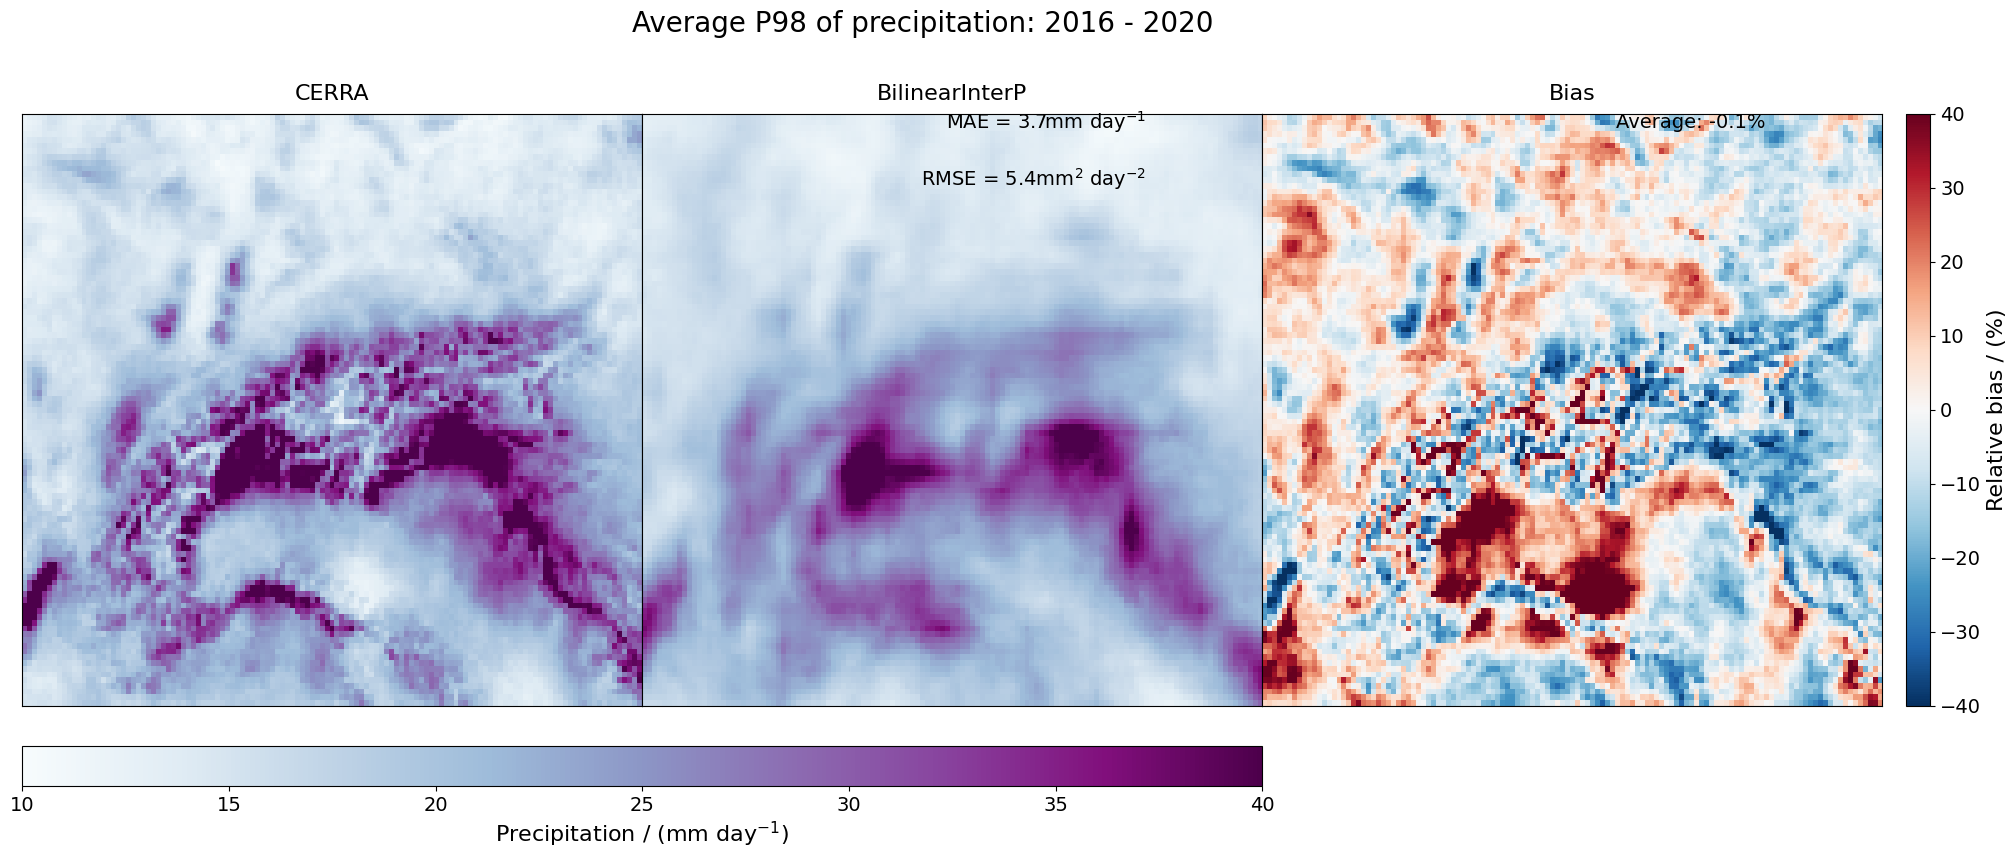

In [37]:
# plot extremes of observation, prediction, and bias
vmin, vmax = 10, 40
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_ex, y_pred_ex, bias_ex], axes):
    if ds is bias_ex:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-40, vmax=40)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='upper', cmap='BuPu', vmin=vmin, vmax=vmax)
        
# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average P{:.0f} of {}: {} - {}'.format(quantile * 100, NAMES[PREDICTAND], start_year, end_year ), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                        0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(label='Relative bias / (%)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / '.format(NAMES[PREDICTAND].capitalize()) + '(mm day$^{-1}$)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.1f}'.format(mae_ex.item())  + 'mm day$^{-1}$', fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.1f}'.format(rmse_ex.item())  + 'mm$^2$ day$^{-2}$', fontsize=14, ha='right')

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Figures/{}_bias_p{:.0f}.png'.format(PREDICTAND, quantile * 100), dpi=300, bbox_inches='tight')

### Bias of extremes: winter vs. summer

In [38]:
# group data by season and compute extreme percentile
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    y_true_ex_snl = y_true.groupby('time.season').quantile(quantile, dim='time')
    y_pred_ex_snl = y_pred_pr.groupby('time.season').quantile(quantile, dim='time')

In [39]:
# compute relative bias in seasonal extremes
bias_ex_snl = ((y_pred_ex_snl - y_true_ex_snl) / y_true_ex_snl) * 100

In [40]:
# print average bias in extreme per season: Insitu:CERRA
for season in bias_ex_snl.season:
    print('({}:{}) Average bias of P{:.0f} for season {}: {:.1f}%'.format(TRUE, PRED, quantile * 100, season.values.item(), bias_ex_snl.sel(season=season).mean().item()))

(CERRA:BilinearInterP) Average bias of P98 for season DJF: 5.8%
(CERRA:BilinearInterP) Average bias of P98 for season JJA: -6.6%
(CERRA:BilinearInterP) Average bias of P98 for season MAM: -2.0%
(CERRA:BilinearInterP) Average bias of P98 for season SON: 0.9%


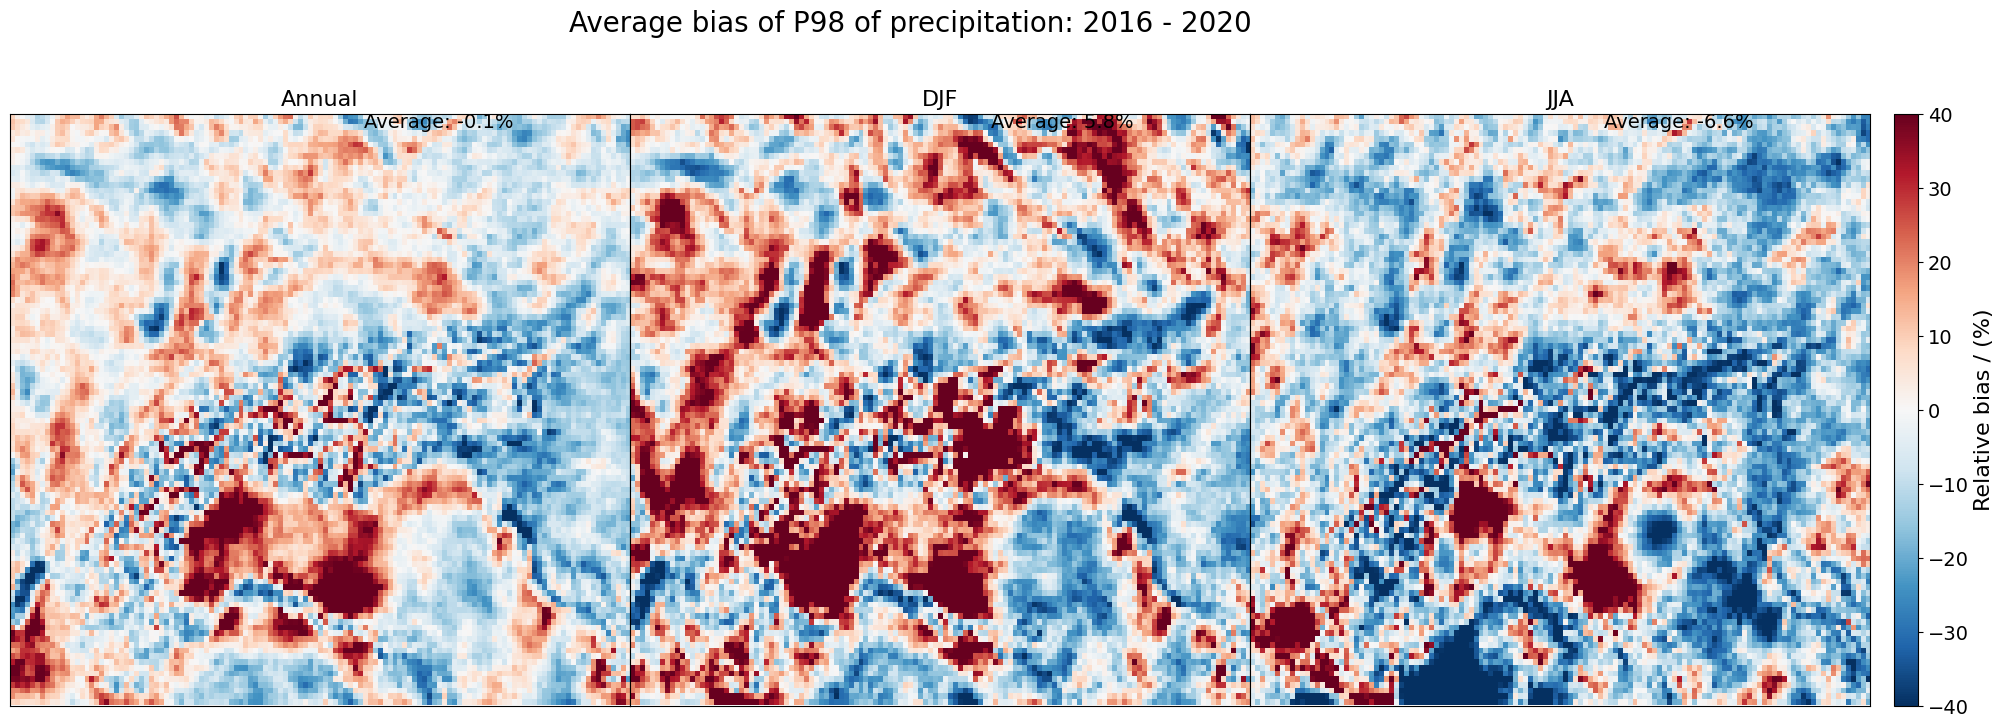

In [41]:
# plot seasonal differences
seasons = ('DJF', 'JJA')
fig, axes = plt.subplots(nrows=1, ncols=len(seasons) + 1, figsize=(24,8), sharex=True, sharey=True)
axes = axes.flatten()

# plot annual average bias of extreme
ds = bias_ex.mean(dim='year')
axes[0].imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-40, vmax=40)
axes[0].set_title('Annual', fontsize=16);
axes[0].text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')

# plot seasonal average bias of extreme
for ax, season in zip(axes[1:], seasons):
    ds = bias_ex_snl.sel(season=season)
    ax.imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-40, vmax=40)
    ax.set_title(season, fontsize=16);
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average bias of P{:.0f} of {}: {} - {}'.format(quantile * 100, NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                        0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(label='Relative bias / (%)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Figures/{}_bias_p{:.0f}_seasonal.png'.format(PREDICTAND, quantile * 100), dpi=300, bbox_inches='tight')

### Frequency of wet days

In [42]:
# minimum precipitation (mm / day) defining a wet day
WET_DAY_THRESHOLD = 1
WET_DAY_THRESHOLD = float(WET_DAY_THRESHOLD)

In [43]:
# true and predicted frequency of wet days
mask = (~np.isnan(y_true)) & (~np.isnan(y_pred_pr))
wet_days_true = (y_true >= WET_DAY_THRESHOLD).where(mask, other=np.nan).astype(np.float32)
wet_days_pred = (y_pred_pr >= WET_DAY_THRESHOLD).where(mask, other=np.nan).astype(np.float32)

In [44]:
# number of wet days in reference period: annual
n_wet_days_true = wet_days_true.sum(dim='time', skipna=False)
n_wet_days_pred = wet_days_pred.sum(dim='time', skipna=False)

In [45]:
# frequency of wet days in reference period: annual
f_wet_days_true = (n_wet_days_true / len(wet_days_true.time)) * 100
f_wet_days_pred = (n_wet_days_pred / len(wet_days_pred.time)) * 100

In [46]:
# frequency of wet days in reference period: seasonal
f_wet_days_true_snl = wet_days_true.groupby('time.season').mean(dim='time', skipna=False)
f_wet_days_pred_snl = wet_days_pred.groupby('time.season').mean(dim='time', skipna=False)

In [47]:
# relative bias of frequency of wet vs. dry days: annual
bias_wet = ((f_wet_days_pred - f_wet_days_true) / f_wet_days_true) * 100

# relative bias of frequency of wet vs. dry days: seasonal
bias_wet_snl = ((f_wet_days_pred_snl - f_wet_days_true_snl) / f_wet_days_true_snl) * 100

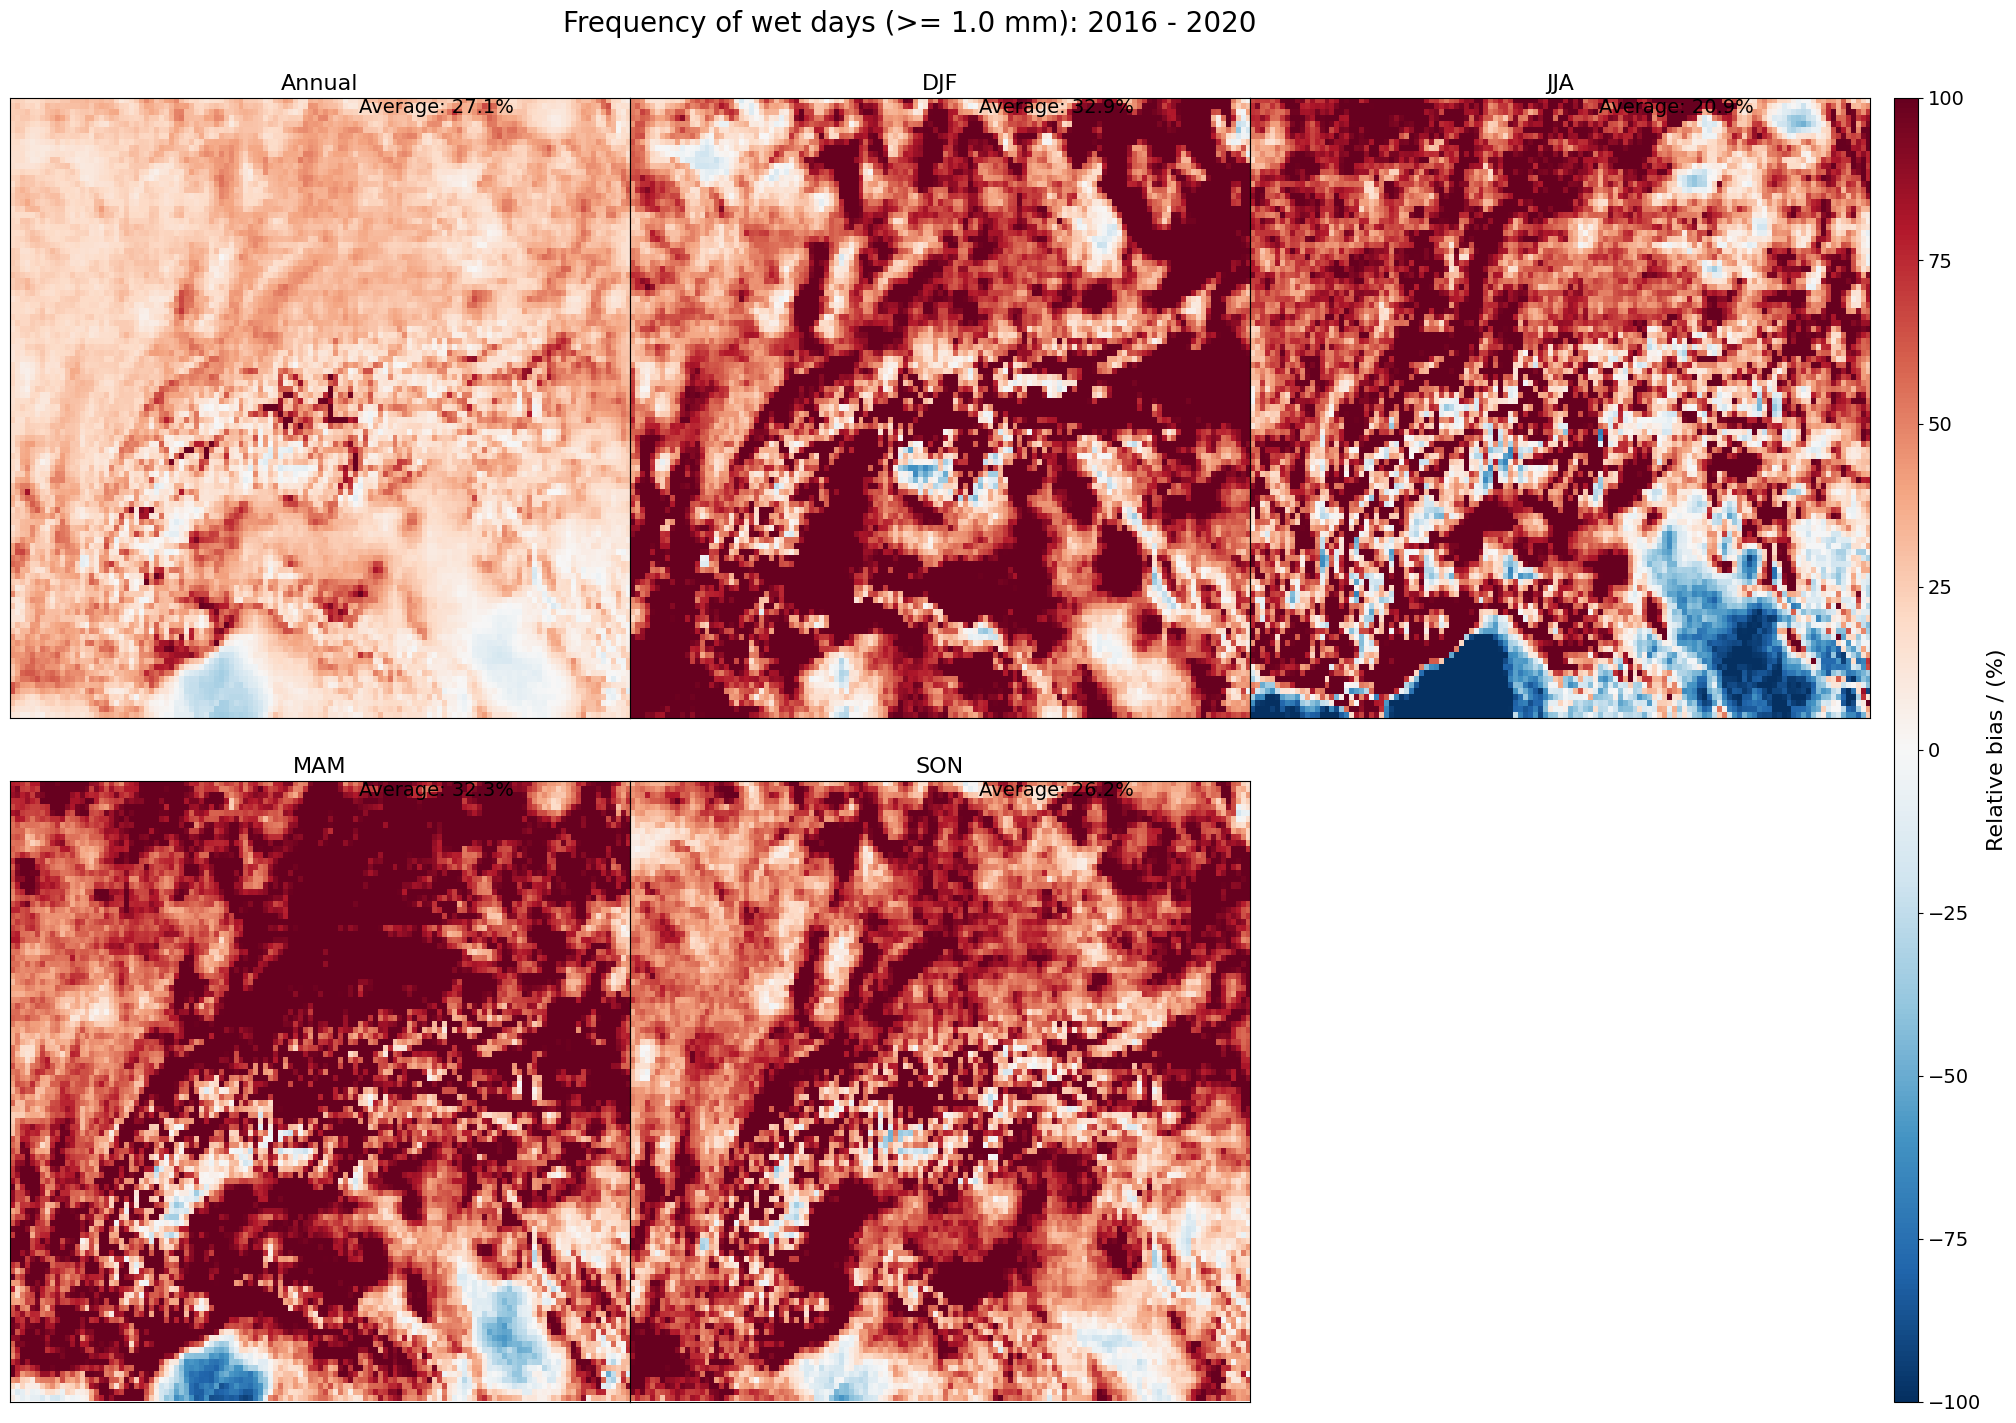

In [48]:
# plot average of observation, prediction, and bias
fig, axes = plt.subplots(2, 3, figsize=(24, 16), sharex=True, sharey=True)
axes = axes.flatten()

# plot annual average bias of extreme
ds = bias_wet
im = axes[0].imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-100, vmax=100)
axes[0].set_title('Annual', fontsize=16);
axes[0].text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')

# plot seasonal average bias of extreme
for ax, season in zip(axes[1:], bias_wet_snl.season):
    ds = bias_wet_snl.sel(season=season)
    ax.imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-40, vmax=40)
    ax.set_title(season.item(), fontsize=16);
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
# turn off last axis
axes[-1].set_visible(False)

# adjust figure
fig.suptitle('Frequency of wet days (>= {:.1f} mm): {} - {}'.format(WET_DAY_THRESHOLD, start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0.1, wspace=0, top=0.925)

# add colorbar
cbar_ax_predictand = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                                   0.01, axes[0].get_position().y1 - axes[-1].get_position().y0])
cbar_predictand = fig.colorbar(im, cax=cbar_ax_predictand)
cbar_predictand.set_label(label='Relative bias / (%)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Figures/{}_bias_wet_day.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Mean wet day precipitation

In [49]:
# calculate mean wet day precipitation
dii_true = (y_true * wet_days_true).sum(dim='time', skipna=False) / n_wet_days_true
dii_pred = (y_pred_pr * wet_days_pred).sum(dim='time', skipna=False) / n_wet_days_pred

In [50]:
# calculate relative bias of mean wet day precipitation
bias_dii = ((dii_pred - dii_true) / dii_true) * 100

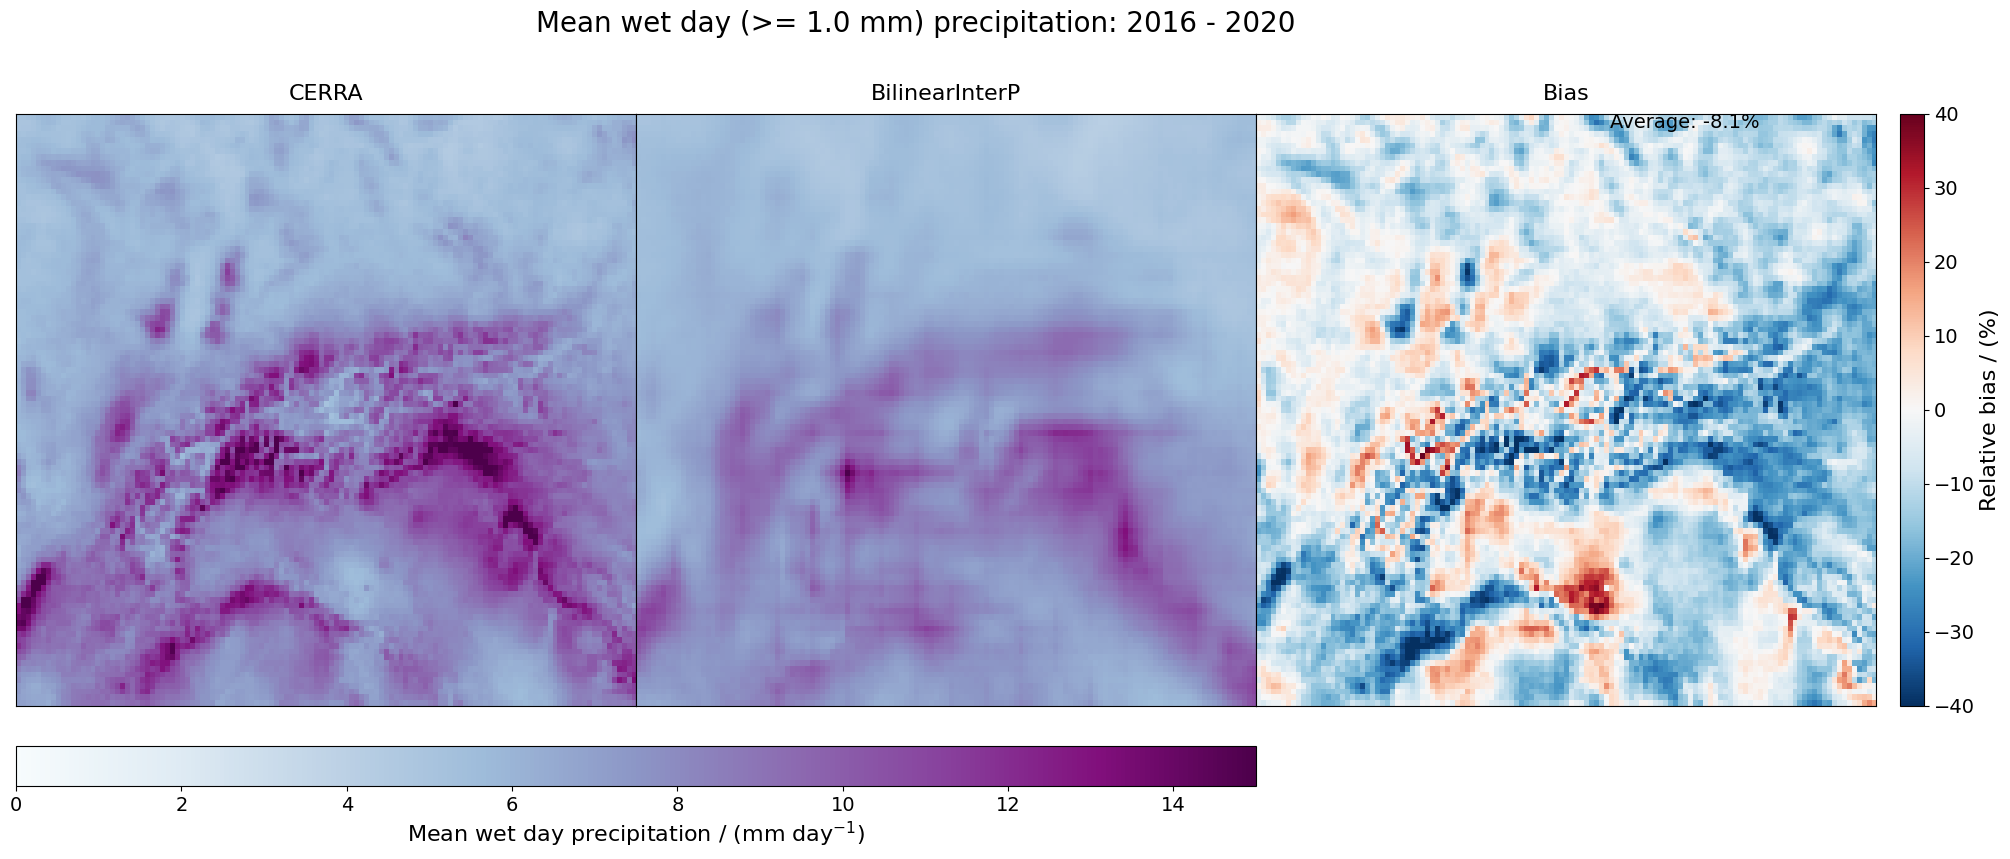

In [51]:
# plot average of observation, prediction, and bias
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
for ds, ax in zip([dii_true, dii_pred, bias_dii], axes):
    if ds is bias_dii:
        im2 = ax.imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-40, vmax=40)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.values, origin='upper', cmap='BuPu', vmin=0, vmax=15)
        
# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Mean wet day (>= {:.1f} mm) precipitation: {} - {}'.format(WET_DAY_THRESHOLD, start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                             0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar_bias = fig.colorbar(im2, cax=cbar_ax_bias)
cbar_bias.set_label(label='Relative bias / (%)', fontsize=16)
cbar_bias.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='Mean wet day precipitation / (mm day$^{-1}$)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Figures/{}_bias_wdp.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

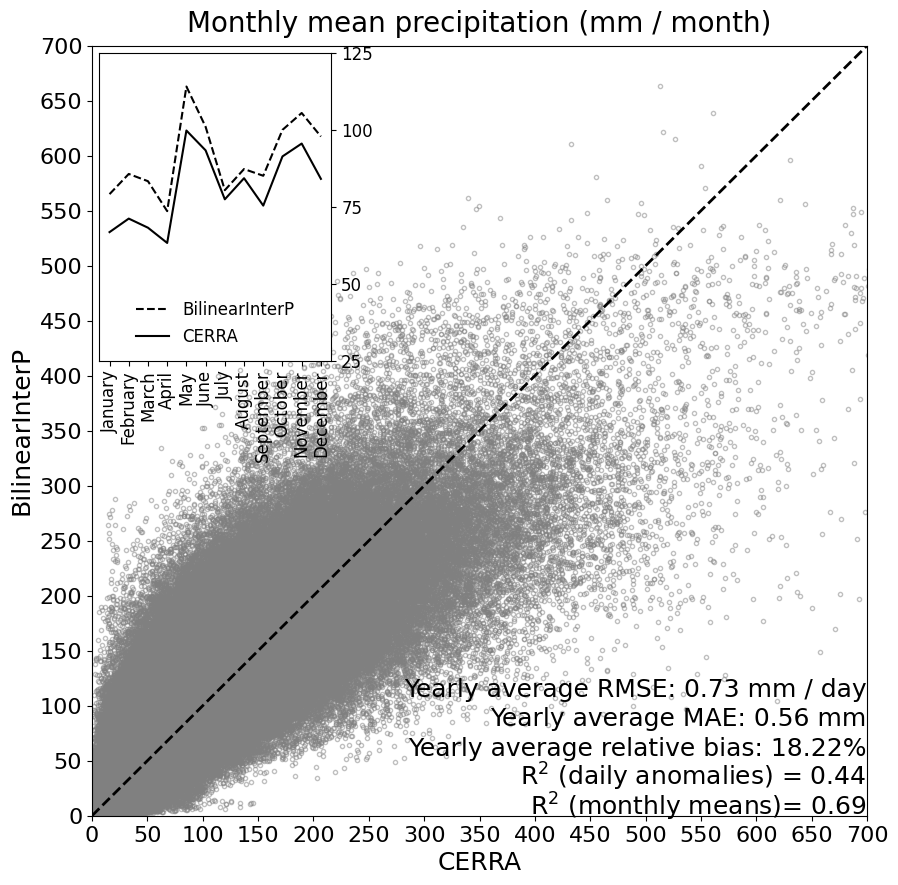

In [52]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot only a subset of data: otherwise plot is overloaded ...
# subset = np.random.choice(np.arange(0, len(y_pred_values)), size=int(1e3), replace=False)
# ax.plot(y_true_values[subset], y_pred_values[subset], 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot 1:1 mapping line
interval = np.arange(0, 750, 50)
ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 27.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 54.5, s='Yearly average relative bias: {:.2f}%'.format(bias_yearly_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 81.5, s='Yearly average MAE: {:.2f} mm'.format(mae_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 108.5, s='Yearly average RMSE: {:.2f} mm / day'.format(rmse_avg.item()), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel(TRUE, fontsize=18)
ax.set_ylabel(PRED, fontsize=18)
ax.set_title('Monthly mean {} (mm / month)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="30%", height="40%", loc=2, borderpad=0.5)
axins.plot(y_pred_ac, ls='--', color='k', label=PRED)
axins.plot(y_true_ac, ls='-', color='k', label=TRUE)
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.set_yticks(np.arange(25, 150, 25))
axins.set_yticklabels(np.arange(25, 150, 25), fontsize=12)
axins.yaxis.tick_right()
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Figures/{}_r2.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')